# Try DBSCAN on PCAd and non-PCAd data

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn import decomposition, metrics
from sklearn.preprocessing import scale, robust_scale
from sklearn.cluster import DBSCAN
#from sklearn.manifold import TSNE
%matplotlib inline

In [2]:
# Read in data
filename = '/Users/tswenson/Documents/Joels/Health_Data_Science/COMPANY_consulting_project/datasets/merged_csvs/LABELLED_by_cell_type_screen_525_cell_plate_1_well_c03.csv'
my_data=pd.read_csv(filename, index_col=0)

In [3]:
# Find data columns
my_data_headers = list(my_data)
meta_headers = ["Width","cell_label","cell_plate","lineage","screen","well","Time"]
my_data_data_headers = [x for x in my_data_headers if not x in meta_headers]
# Scale the data columns
my_scaled_data = scale(my_data[my_data_data_headers])
# Make a list where cell_label is converted to numbers for plotting
word_as_num=[]
for word in my_data['cell_label']:
    if word == "unlabelled":
        word_as_num.append("0")
    if word == "blast":
        word_as_num.append("0.5")
    if word == "healthy":
        word_as_num.append("1")

In [4]:
# Do PCA
# Perform PCA
pca = decomposition.PCA()
pca.fit(my_scaled_data)

PCA(copy=True, n_components=None, whiten=False)

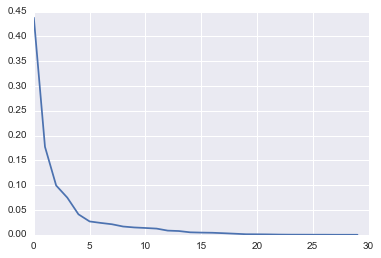

In [5]:
# Plot var explained per component
#The amount of variance that each PC explains
var=pca.explained_variance_ratio_
plt.plot(var)

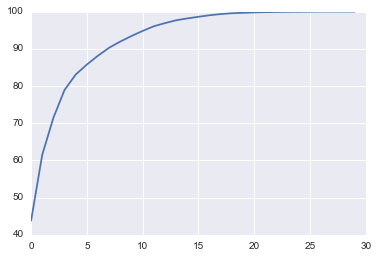

In [6]:
#Cumulative Variance explains
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
plt.plot(var1)

In [7]:
# Transform my data based on the PCA results
pca = decomposition.PCA(n_components = 10)
my_scaled_data_transformed = pca.fit_transform(my_scaled_data)

In [8]:
# Convert transformed data into a pandas dataframe and then combine it with the meta data
my_scaled_data_transformed_pd = pd.DataFrame(my_scaled_data_transformed)

# Combine it with the meta data
my_scaled_data_transformed_pd_meta = pd.concat([my_scaled_data_transformed_pd, my_data[meta_headers]], axis=1);
# Note that the above line works because they have the same index, if they didn't and I 
## wanted to perform a cbind, I could say my_scaled_data_transformed_pd.reset_index(drop=True)

In [9]:
print(my_data[meta_headers].head(n=2))
print("NEXT------------------------")
print(my_scaled_data_transformed_pd.head(n=2))
print("NEXT------------------------")
print(my_scaled_data_transformed_pd_meta.head(n=2))

    Width  cell_label    cell_plate lineage      screen      well    Time
0  5288.0  unlabelled  cell_plate_1  parent  screen_525  well_c03  8377.0
1    36.0  unlabelled  cell_plate_1  parent  screen_525  well_c03  8377.0
NEXT------------------------
           0          1          2          3          4          5  \
0 -43.121483 -13.213300  84.447944  65.967352 -62.290093 -12.051844   
1   0.722782   0.013042   1.482393  -0.021735  -0.747183   0.620734   

           6         7         8         9  
0 -20.514740 -6.116185 -1.487347  5.565701  
1   1.950387  0.500923  0.290362  0.043254  
NEXT------------------------
           0          1          2          3          4          5  \
0 -43.121483 -13.213300  84.447944  65.967352 -62.290093 -12.051844   
1   0.722782   0.013042   1.482393  -0.021735  -0.747183   0.620734   

           6         7         8         9   Width  cell_label    cell_plate  \
0 -20.514740 -6.116185 -1.487347  5.565701  5288.0  unlabelled  cell_plate_1 

In [12]:
# Do DBSCAN on the PCAd data
print("Starting DBSCAN")
dbsc = DBSCAN(eps = .6,min_samples=10).fit(my_scaled_data_transformed_pd)
labels = dbsc.labels_
core_samples = np.zeros_like(labels, dtype = bool)
core_samples[dbsc.core_sample_indices_] = True
unique_labels = np.unique(labels)
'''
print("Plotting DBSCAN")
# Plot the DBSCAN results
plt.figure(figsize=(20, 10))
plt.gcf().clear()
plt.subplot(121)
col = np.linspace(0,1,len(unique_labels))
for i in xrange(len(unique_labels)):
    plt.plot(tsne_out_mink[np.where(labels==unique_labels[i])[0], 0], 
         tsne_out_mink[np.where(labels==unique_labels[i])[0], 1],
            #'o', mfc=plt.cm.viridis(col[i]), label=unique_labels[i])
            'o', mfc=plt.cm.nipy_spectral(col[i]), label=unique_labels[i])
            #'o', mfc=plt.cm.prism(col[i]), label=unique_labels[i])
            #'o', mfc=plt.cm.flag(col[i]), label=unique_labels[i])
plt.legend(loc='best', frameon=False)
plt.savefig(filename + "__DBSCAN_of_tsne.png")
plt.close()
'''

Starting DBSCAN


'\nprint("Plotting DBSCAN")\n# Plot the DBSCAN results\nplt.figure(figsize=(20, 10))\nplt.gcf().clear()\nplt.subplot(121)\ncol = np.linspace(0,1,len(unique_labels))\nfor i in xrange(len(unique_labels)):\n    plt.plot(tsne_out_mink[np.where(labels==unique_labels[i])[0], 0], \n         tsne_out_mink[np.where(labels==unique_labels[i])[0], 1],\n            #\'o\', mfc=plt.cm.viridis(col[i]), label=unique_labels[i])\n            \'o\', mfc=plt.cm.nipy_spectral(col[i]), label=unique_labels[i])\n            #\'o\', mfc=plt.cm.prism(col[i]), label=unique_labels[i])\n            #\'o\', mfc=plt.cm.flag(col[i]), label=unique_labels[i])\nplt.legend(loc=\'best\', frameon=False)\nplt.savefig(filename + "__DBSCAN_of_tsne.png")\nplt.close()\n'

In [14]:
DB_PCA = [] # This will be a list of lists where the 1st entry is the cluster ID, 2nd: is
## how many "unlabelled" are in that cluster, 3rd: number of blast, 4th: number of healthy.
for i in xrange(len(unique_labels)):
    clst_index = my_data['cell_label'][np.where(labels==unique_labels[i])[0]]
    if clst_index.empty == True:
        print("Cluster index and original data don't line up right. STOP AND FIX")
        break
    DB_PCA.append([unique_labels[i],sum(clst_index=='unlabelled'),
                     sum(clst_index=='blast'),sum(clst_index=='healthy')])
    #print(str(unique_labels2[i])+"--") # prints cluster name plus two "--"s
    #print len(tsne_out_mink2[np.where(labels2==unique_labels2[i])[0],0]) # prints how many cells are in that cluster
print(DB_PCA) # This was print(tsne_db_2)

[[-1, 1426, 94, 160], [0, 6953, 83, 333], [1, 3, 12, 0], [2, 17, 0, 0]]


(3.0, 10000.0)

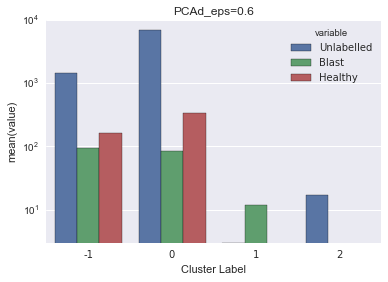

In [27]:
# Convert the list of lists to a pandas dataframe
DB_PCA_df = pd.DataFrame(DB_PCA,columns=["Cluster Label","Unlabelled","Blast","Healthy"])
DB_PCA_df_melted = pd.melt(DB_PCA_df,value_vars=["Unlabelled","Blast","Healthy"],id_vars="Cluster Label")
# Plot the results
ax = sns.barplot(hue="variable",y="value",x="Cluster Label",data=DB_PCA_df_melted,log='y')
plt.title("PCAd_eps=0.6")
plt.ylim(0, plt.ylim()[1])
#plt.ylim(plt.ylim()[0]-100, plt.ylim()[1])

In [ ]:
'''
### Only plot clusters with more than 50 events
tsne_db_df_50 = tsne_db_df[tsne_db_df.sum(axis=1)>50]
tsne_db_df_50_melted = pd.melt(tsne_db_df_50,value_vars=["Unlabelled","Blast","Healthy"],id_vars="Cluster Label")
ax = sns.barplot(hue="variable",y="value",x="Cluster Label",data=tsne_db_df_50_melted,log='y')
plt.savefig('C03_large_clstrs_only__barplot.png')
plt.close()
'''

# Automate the above and play with the hyper-parameters

In [10]:
eps_param = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.4, 1.8, 3, 6, 12]
algorithm_ = ["auto", "ball_tree","kd_tree","brute"]
metric_ = ["cityblock","euclidean","l1","l2","manhattan",\
           "chebyshev", \
           "dice", "hamming", "jaccard", "kulsinski", \
           "matching", "rogerstanimoto", "russellrao",\
           "sokalmichener", "sokalsneath", "yule"]
# metric not run with auto: "cosine", "correlation", "mahalanobis", \
# "minkowski", "seuclidean", "sqeuclidean", "yule"
# "braycurtis", "canberra" only run with auto and ball_tree

In [11]:

metric_ = ["jaccard", "kulsinski", \
           "matching", "rogerstanimoto", "russellrao",\
           "sokalmichener", "sokalsneath", "yule"]
metric_auto_only = [ "braycurtis", "canberra",\
           "dice", "hamming","jaccard", "kulsinski", \
           "matching", "rogerstanimoto", "russellrao",\
           "sokalmichener", "sokalsneath", "yule"]

In [14]:
metric_ = ["canberra"]
eps_param = [float(x)/20 for x in list(range(20,70,1))]
eps_param

[1.0,
 1.05,
 1.1,
 1.15,
 1.2,
 1.25,
 1.3,
 1.35,
 1.4,
 1.45,
 1.5,
 1.55,
 1.6,
 1.65,
 1.7,
 1.75,
 1.8,
 1.85,
 1.9,
 1.95,
 2.0,
 2.05,
 2.1,
 2.15,
 2.2,
 2.25,
 2.3,
 2.35,
 2.4,
 2.45,
 2.5,
 2.55,
 2.6,
 2.65,
 2.7,
 2.75,
 2.8,
 2.85,
 2.9,
 2.95,
 3.0,
 3.05,
 3.1,
 3.15,
 3.2,
 3.25,
 3.3,
 3.35,
 3.4,
 3.45]

In [15]:
for met in metric_:
    for algo in algorithm_:
        if met in metric_auto_only:
            if algo != "auto":
                continue
        for eps_ in eps_param:
            dbsc = None; labels = None; DB_PCA = None; DB_PCA_df = None;
            # Do DBSCAN on the PCAd data
            print("Starting DBSCAN with EPS of " + str(eps_) + " ALGORITHM of " + algo\
                 + " distance METRIC of " + met)
            dbsc = DBSCAN(eps = eps_,min_samples=10, algorithm = algo, metric = met).fit(my_scaled_data_transformed_pd)
            labels = dbsc.labels_
            core_samples = np.zeros_like(labels, dtype = bool)
            core_samples[dbsc.core_sample_indices_] = True
            unique_labels = np.unique(labels)

            # Done with DBSCAN, plot it
            DB_PCA = [] # This will be a list of lists where the 1st entry is the cluster ID, 2nd: is
            ## how many "unlabelled" are in that cluster, 3rd: number of blast, 4th: number of healthy.
            for i in xrange(len(unique_labels)):
                clst_index = my_data['cell_label'][np.where(labels==unique_labels[i])[0]]
                if clst_index.empty == True:
                    print("Cluster index and original data don't line up right. STOP AND FIX")
                    break
                DB_PCA.append([unique_labels[i],sum(clst_index=='unlabelled'),
                                 sum(clst_index=='blast'),sum(clst_index=='healthy')])
                #print(str(unique_labels2[i])+"--") # prints cluster name plus two "--"s
                #print len(tsne_out_mink2[np.where(labels2==unique_labels2[i])[0],0]) # prints how many cells are in that cluster
            print(DB_PCA) # This was print(tsne_db_2)

            # Convert the list of lists to a pandas dataframe
            DB_PCA_df = pd.DataFrame(DB_PCA,columns=["Cluster Label","Unlabelled","Blast","Healthy"])
            DB_PCA_df_melted = pd.melt(DB_PCA_df,value_vars=["Unlabelled","Blast","Healthy"],id_vars="Cluster Label")

            # Plot the results
            plt.gcf().clear()
            ax = sns.barplot(hue="variable",y="value",x="Cluster Label",data=DB_PCA_df_melted,log='y')
            plt.title("DBSCAN results with eps of " + str(eps_))
            plt.ylim(0, plt.ylim()[1])
            plt.savefig(filename + "__PCA10_DBSCAN_eps-" + str(eps_) + "_algo-" + algo + "_dist-metric-" + met + "_results.png")
            plt.close()
            print("Done with iteration with EPS of " + str(eps_) + " ALGORITHM of " + algo\
                 + " distance METRIC of " + met)


Starting DBSCAN with EPS of 1.0 ALGORITHM of auto distance METRIC of canberra
[[-1, 7932, 185, 493], [0, 81, 0, 0], [1, 12, 0, 0], [2, 26, 0, 0], [3, 15, 0, 0], [4, 5, 0, 0], [5, 43, 0, 0], [6, 25, 0, 0], [7, 1, 4, 0], [8, 128, 0, 0], [9, 5, 0, 0], [10, 22, 0, 0], [11, 27, 0, 0], [12, 17, 0, 0], [13, 5, 0, 0], [14, 7, 0, 0], [15, 5, 0, 0], [16, 5, 0, 0], [17, 5, 0, 0], [18, 6, 0, 0], [19, 11, 0, 0], [20, 6, 0, 0], [21, 5, 0, 0], [22, 5, 0, 0]]
Done with iteration with EPS of 1.0 ALGORITHM of auto distance METRIC of canberra
Starting DBSCAN with EPS of 1.05 ALGORITHM of auto distance METRIC of canberra
[[-1, 7796, 180, 493], [0, 6, 0, 0], [1, 12, 0, 0], [2, 108, 0, 0], [3, 5, 0, 0], [4, 37, 0, 0], [5, 28, 0, 0], [6, 15, 0, 0], [7, 7, 0, 0], [8, 43, 0, 0], [9, 49, 0, 0], [10, 1, 4, 0], [11, 164, 0, 0], [12, 0, 5, 0], [13, 5, 0, 0], [14, 23, 0, 0], [15, 28, 0, 0], [16, 7, 0, 0], [17, 7, 0, 0], [18, 5, 0, 0], [19, 5, 0, 0], [20, 4, 0, 0], [21, 5, 0, 0], [22, 11, 0, 0], [23, 4, 0, 0], [24, 